### Interpretability of DNN: Visualization of extreme events
#### Visualize extreme events

In [80]:
# Important to note:!
# The use of innvestigate requires specific versions of python and keras
# The model must be built according to the versions, so the weights are saved separately
# import necesssary libaries
from pathlib import Path
import pathlib
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
#for plotting
import geopandas as gpd

from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

from utils.utils_unet import *
from utils.utils_plot import *
from utils.DNN_models import *
from utils.utils_LRP import *


import innvestigate
import innvestigate.utils as iutils
import innvestigate.applications.imagenet
import innvestigate.utils.visualizations as ivis

import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')  #catch FutureWarnings so that I can find actual errors!
    
    import keras
    import keras.backend as K
    import keras.models
    #import tensorflow as tf  # this is new for custom loss function
    from keras.models import load_model
    
    from keras.layers import Input, Dense, Activation, Dropout, Flatten, MaxPooling2D, Conv2D, Conv2DTranspose, UpSampling2D, Reshape
    from keras.models import Model
    
    from keras.utils import CustomObjectScope
    from keras.initializers import glorot_uniform
    import yaml

In [81]:
DIR_WEIGHTS = '/storage/homefs/no21h426/precip-predict/tmp/keras/'

In [82]:
conf = yaml.safe_load(open("config.yaml"))
i_shape = conf['i_shape']
o_shape = conf['o_shape']

print(f'X shape: {i_shape}')
print(f'y shape: {o_shape}')
output_channels = conf['output_channels']
num_filters = conf['num_filters']
use_batchnorm = conf['use_batchnorm']
dropout = conf['dropout']
lr = conf['lr']

name_model = conf['model']
output_scaling = 1
output_crop = None

X shape: [46, 56, 31]
y shape: [46, 56, 1]


In [83]:
def convert_to_xarray(a, vnames, time, lats_y, lons_x):
    """Convert numpy array to xarray"""
    mx= xr.DataArray(a, dims=["time","lat", "lon", "variable"],
                  coords=dict(time = time,
                              lat = lats_y, lon = lons_x, variable= vnames ))
        
    return(mx)

In [84]:
# test-times
times = np.arange(np.datetime64('2016-01-01'), np.datetime64('2021-12-31'))
times = pd.to_datetime(times)
# load the training and testing data
dg_test_Y_xtrm = np.array(xr.open_dataarray('tmp/data/dg_test_Y_xtrm0.95th.nc'))
dg_test_Y = np.array(xr.open_dataarray('tmp/data/dg_test_Y.nc'))

dg_test_X = np.array(xr.open_dataarray('tmp/data/dg_test_X.nc'))
dg_test_X_zeros = np.zeros_like(dg_test_X, dtype=float) # just for testing purposes regarding the baseline

In [85]:
#load predictions --numpy array
y_pred1_test = np.load('tmp/data/predictions/y_pred_test_UNET10.95th.npy')
y_pred4_test = np.load('tmp/data/predictions/y_pred_test_UNET40.95th.npy')
y_pred1_bool = y_pred1_test >= 0.5
y_pred1_bool = y_pred1_bool * 1
y_pred4_bool = y_pred4_test >= 0.5
y_pred4_bool = y_pred4_bool * 1

### Visualize events to analyse

In [86]:
#select one day # e.g. select the flood in July 2021, days: 12-15
idx = np.where(times == '2021-07-14')

In [87]:
idx = int(idx[0])

In [88]:
nx = dg_test_X.shape[1]
ny = dg_test_X.shape[2]
nchans = dg_test_X.shape[3]

In [89]:
i_max_obs=1016

In [90]:
times[i_max_obs]

Timestamp('2018-10-13 00:00:00')

In [91]:
i_shape = conf['i_shape']
o_shape = conf['o_shape']

print(f'X shape: {i_shape}')
print(f'y shape: {o_shape}') 
                                            
#  Default model options
opt_model = {'latent_dim': 128,
             'dropout_rate': 0.2}

# Default optimizer options
opt_optimizer = {'lr_method': 'Constant',
                 'lr': 0.0004,
                 'init_lr': 0.01}


models_unets = {
          'UNET1': {'model': 'Unet', 'run': False,
                   'opt_model': {'output_scaling': output_scaling, 'output_crop': output_crop, 'unet_depth': 1, 'use_upsample': False},
                   'opt_optimizer': {'lr_method': 'Constant'}},
          'UNET2': {'model': 'Unet', 'run': True,
                   'opt_model': {'output_scaling': output_scaling, 'output_crop': output_crop, 'unet_depth': 2, 'use_upsample': False},
                   'opt_optimizer': {'lr_method': 'Constant'}},
          'UNET3': {'model': 'Unet', 'run': False,
                   'opt_model': {'output_scaling': output_scaling, 'output_crop': output_crop, 'unet_depth': 3, 'use_upsample': False},
                   'opt_optimizer': {'lr_method': 'Constant'}},
          'UNET4': {'model': 'Unet', 'run': False,
                   'opt_model': {'output_scaling': output_scaling, 'output_crop': output_crop, 'unet_depth': 4, 'use_upsample': False},
                   'opt_optimizer': {'lr_method': 'Constant'}},
         }

X shape: [46, 56, 31]
y shape: [46, 56, 1]


In [92]:
models_prec =[]
models_xtrm = []
models = models_unets

In [93]:
# load for extremes
# load weights
for m_id in models:
    
    if not models[m_id]['run']:
        continue
    print(m_id)
    # Extract model name and options
    model = models[m_id]['model']
    opt_model_i = models[m_id]['opt_model']
    opt_optimizer_i = models[m_id]['opt_optimizer']
    opt_model_new = opt_model.copy()
    opt_model_new.update(opt_model_i)
    opt_optimizer_new = opt_optimizer.copy()
    opt_optimizer_new.update(opt_optimizer_i)

    m = DeepFactory_Keras(model, i_shape, o_shape, for_extremes=True, for_lrp = True, **opt_model_new)
    m.model.load_weights(f'{DIR_WEIGHTS}ERA5-low_0.95_{m_id}_xtrm.h5')
    
    #m_prec = DeepFactory_Keras(model, i_shape, o_shape, for_extremes=False,  for_lrp = True, **opt_model_new)
    # compile 
    #m_prec.model.compile(loss='mse',  metrics=['mse'],  optimizer='adam')
    print('loads weigths for extremes')
    #m.model.summary()
    # load weights
    #print("loading weights for",m_id)
    #m_prec.model.load_weights(f'{DIR_WEIGHTS}ERA5-low_0.95_{m_id}.h5')
    
    models_xtrm.append(m)

UNET2
loads weigths for extremes


In [94]:
rel_compflat_UNET2_2018= calLRP(dg_test_X[i_max_obs-1:i_max_obs+2,:,:,:],models_xtrm[0].model, 'compflat', only_positive=False )
rel_compflat_UNET2_2021= calLRP(dg_test_X[idx-1:idx+2,:,:,:],models_xtrm[0].model, 'compflat', only_positive=False )


In [122]:
rel_UNET2_2018_avg = rel_compflat_UNET2_2018.mean(axis=3)
rel_UNET2_2021_avg = rel_compflat_UNET2_2021.mean(axis=3)

In [138]:
pr = dg_test_Y_xtrm[idx-1:idx+2,...].squeeze()

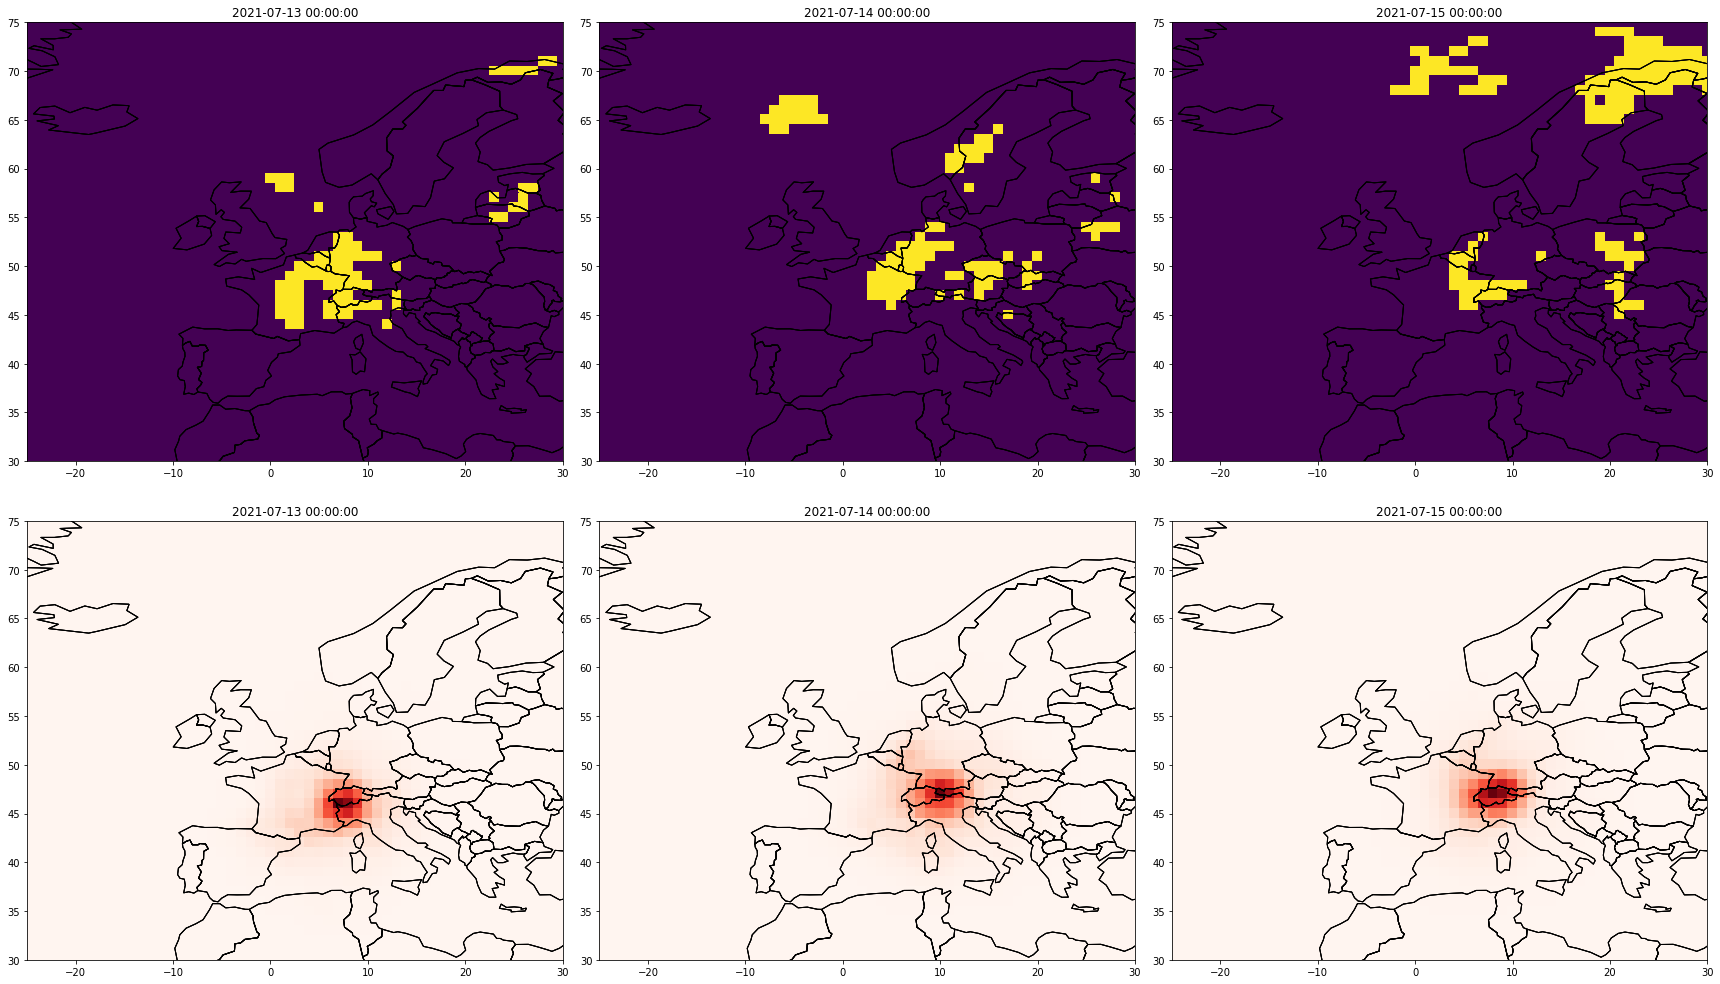

In [139]:
idates21 = times[idx-1:idx+2]
fig, axes = plt.subplots(figsize=(24, 14), ncols=3, nrows=2)
pr = dg_test_Y_xtrm[idx-1:idx+2,...].squeeze()
for i in range(3):

    plot_map(axes[0,i], lons_x, lats_y, pr[i,...], title=idates21[i], show_colorbar=False)
    plot_map(axes[0,i], lons_x, lats_y, pr[i,...], title=idates21[i], show_colorbar=False)
    plot_map(axes[0,i], lons_x, lats_y, pr[i,...], title=idates21[i], show_colorbar=False)
    plot_map(axes[1,i], lons_x, lats_y, rel_UNET2_2021_avg[i,...], title=idates21[i], cmap='Reds', show_colorbar=False)
    plot_map(axes[1,i], lons_x, lats_y, rel_UNET2_2021_avg[i,...], title=idates21[i], cmap='Reds', show_colorbar=False)
    plot_map(axes[1,i], lons_x, lats_y, rel_UNET2_2021_avg[i,...], title=idates21[i], cmap='Reds', show_colorbar=False)
    
# Save figure
fig.tight_layout()
plt.savefig('figures/Event_2021_evolution.pdf')

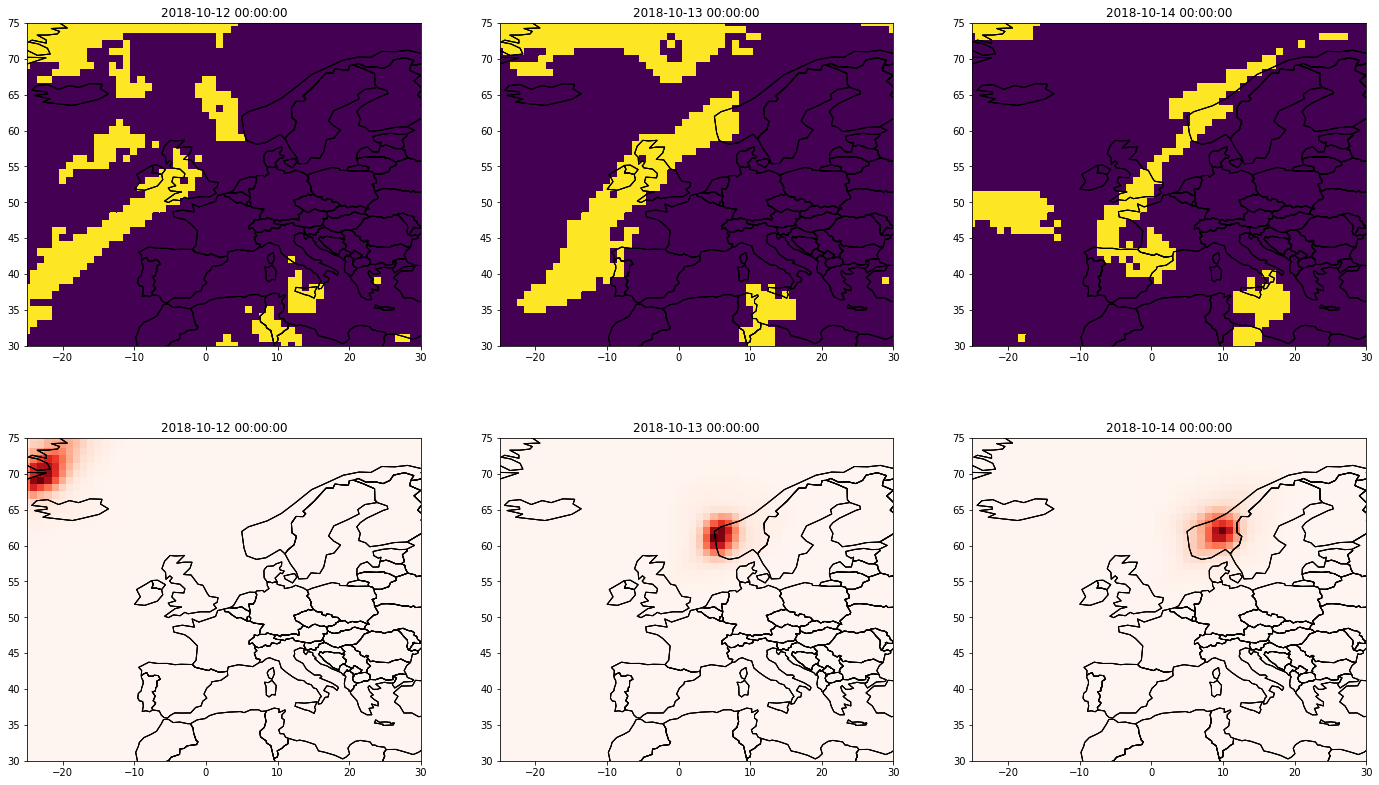

In [140]:
# save event 2018
idates18 = times[i_max_obs-1:i_max_obs+2]
fig, axes = plt.subplots(figsize=(24, 14), ncols=3, nrows=2)
pr = dg_test_Y_xtrm[i_max_obs-1:i_max_obs+2,...].squeeze()
for i in range(3):

    plot_map(axes[0,i], lons_x, lats_y, pr[i,...], title=idates18[i], show_colorbar=False)
    plot_map(axes[0,i], lons_x, lats_y, pr[i,...], title=idates18[i], show_colorbar=False)
    plot_map(axes[0,i], lons_x, lats_y, pr[i,...], title=idates18[i], show_colorbar=False)
    plot_map(axes[1,i], lons_x, lats_y, rel_UNET2_2018_avg[i,...], title=idates18[i], cmap='Reds', show_colorbar=False)
    plot_map(axes[1,i], lons_x, lats_y, rel_UNET2_2018_avg[i,...], title=idates18[i], cmap='Reds', show_colorbar=False)
    plot_map(axes[1,i], lons_x, lats_y, rel_UNET2_2018_avg[i,...], title=idates18[i], cmap='Reds', show_colorbar=False)
    
# Save figure
plt.savefig('figures/Event_2018_evolution.pdf')